<a href="https://colab.research.google.com/github/agrawalrishabh06/ChatApplication/blob/master/Image_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from pycocotools.coco import COCO
import urllib
import zipfile

import numpy as np
import pandas as pd
import cv2
from glob import glob

In [2]:
with zipfile.ZipFile('archive.zip' , 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
from google.colab.patches import cv2_imshow
from skimage import io

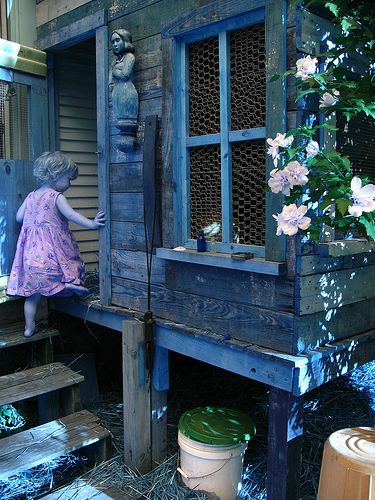

In [5]:
img_path = "/content/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg"
image = io.imread(img_path)
cv2_imshow(image)

In [7]:
images_path = '/content/Flickr8k_Dataset/Flicker8k_Dataset/'
images = glob(images_path+'*.jpg')
len(images)

8091

In [8]:
images[:5]

['/content/Flickr8k_Dataset/Flicker8k_Dataset/2714878018_1593c38d69.jpg',
 '/content/Flickr8k_Dataset/Flicker8k_Dataset/241346885_f519ece460.jpg',
 '/content/Flickr8k_Dataset/Flicker8k_Dataset/3014169370_fc4059352e.jpg',
 '/content/Flickr8k_Dataset/Flicker8k_Dataset/2196050115_e236d91f52.jpg',
 '/content/Flickr8k_Dataset/Flicker8k_Dataset/3568197730_a071d7595b.jpg']

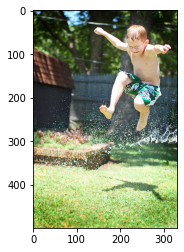

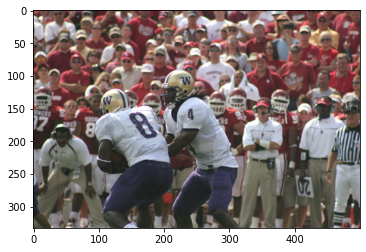

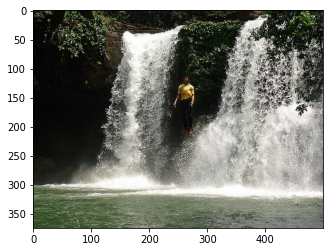

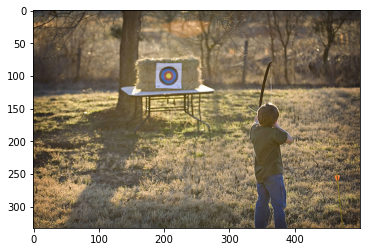

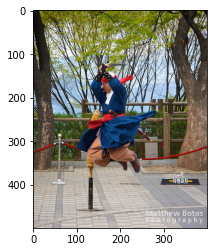

In [9]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [10]:
from keras.applications import ResNet50

incept_model = ResNet50(include_top=True)

102967424/102967424 [==============================] - 1s 0us/step


In [11]:
from keras.models import Model
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 1499:
        break
        
    elif count % 50 == 0:
        print(count)

1/1 [==============================] - 0s 224ms/step
50
1/1 [==============================] - 0s 209ms/step
100
1/1 [==============================] - 0s 214ms/step
150
1/1 [==============================] - 0s 198ms/step
200
1/1 [==============================] - 0s 230ms/step
250
1/1 [==============================] - 0s 205ms/step
300
1/1 [==============================] - 0s 206ms/step
350
1/1 [==============================] - 0s 203ms/step
400
1/1 [==============================] - 0s 208ms/step
450
1/1 [==============================] - 0s 243ms/step
500
1/1 [==============================] - 0s 211ms/step
550
1/1 [==============================] - 0s 207ms/step
600
1/1 [==============================] - 0s 209ms/step
650
1/1 [==============================] - 0s 209ms/step
700
1/1 [==============================] - 0s 213ms/step
750
1/1 [==============================] - 0s 213ms/step
800
1/1 [==============================] - 0s 208ms/step
850
1/1 [===========================

In [13]:
len(images_features)

1500

In [14]:
caption_path = '/content/Flickr8k_text/Flickr8k.token.txt'

In [15]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [16]:
len(captions)

40461

In [86]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
            
    except:
        pass

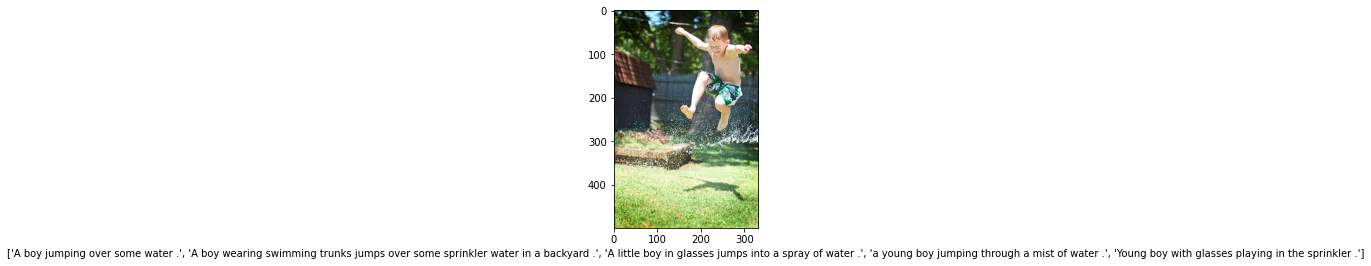

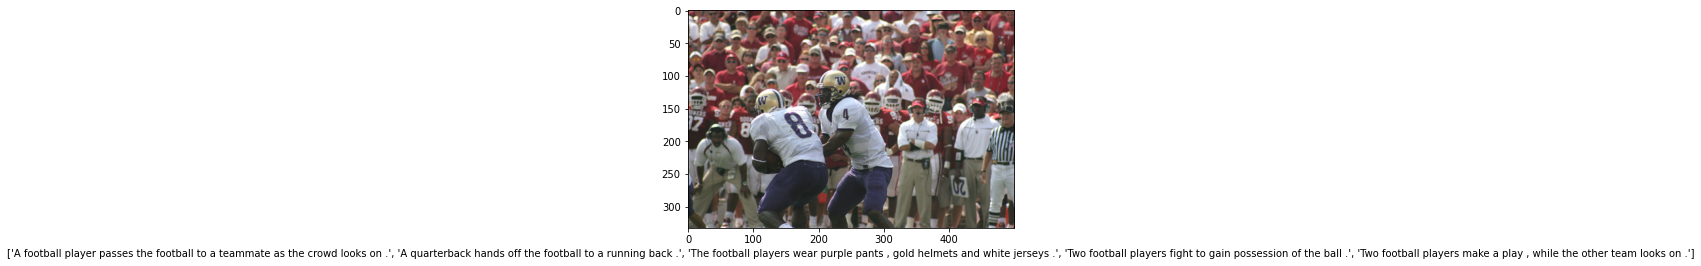

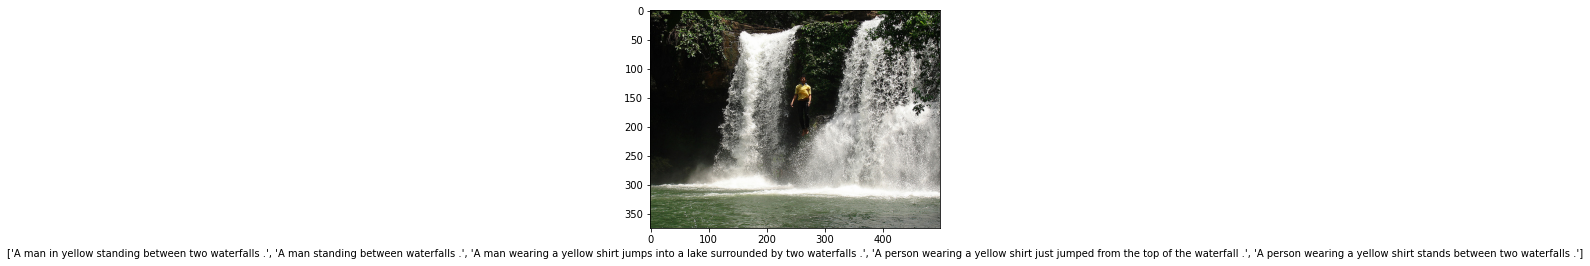

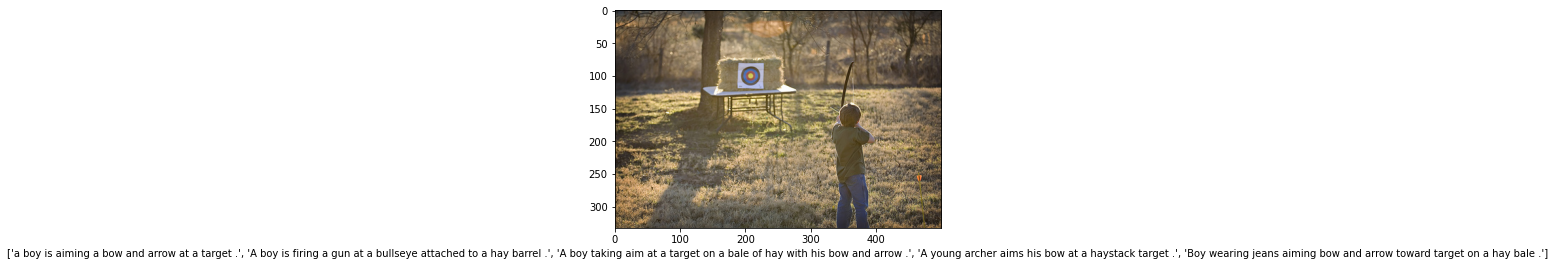

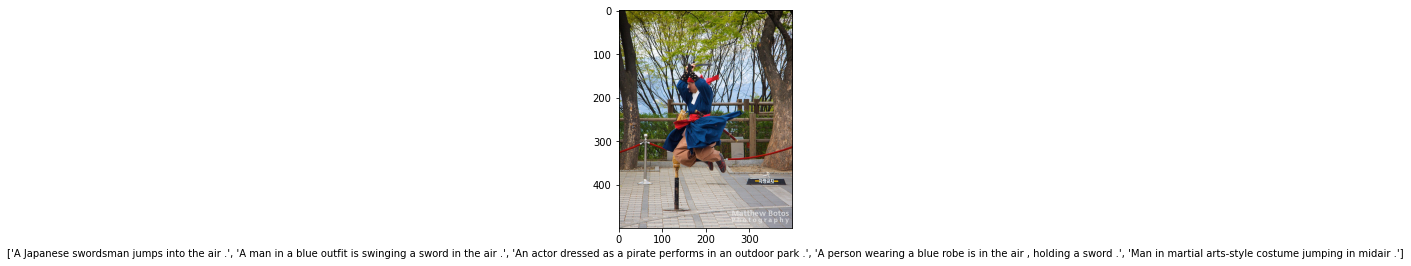

In [87]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img_name = images[i]
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

In [88]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified

In [89]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

In [90]:
count_words = {}
count =1
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:
                count_words[word] = count
                count +=1

In [30]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1

In [91]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():  
            encoded.append(count_words[word])


        captions_dict[k][vv.index(v)] = encoded

In [92]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


In [93]:
MAX_LEN = 0
for k,vv in captions_dict.items():
  for v in vv:
    if len(v) > MAX_LEN:
      MAX_LEN = len(v)
      print(v)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 16, 17, 14, 15, 18, 19, 2, 20, 7, 11, 12]
[1, 24, 3, 16, 25, 26, 18, 19, 15, 14, 5, 6, 7, 11, 12]
[1, 2, 46, 14, 47, 48, 18, 49, 4, 2, 50, 51, 52, 53, 2, 47, 54, 11, 12]
[1, 2, 74, 98, 16, 2, 99, 100, 101, 4, 102, 16, 103, 104, 105, 24, 95, 62, 102, 11, 12]
[1, 24, 127, 118, 81, 128, 129, 78, 79, 24, 80, 125, 24, 46, 118, 130, 102, 4, 24, 131, 11, 12]
[1, 112, 180, 113, 181, 16, 2, 84, 14, 6, 87, 113, 116, 4, 182, 68, 4, 61, 62, 2, 88, 11, 12]
[1, 2, 3, 213, 29, 2, 214, 4, 2, 207, 208, 215, 2, 66, 216, 14, 2, 84, 217, 16, 5, 218, 219, 11, 12]
[1, 112, 403, 4, 628, 629, 93, 592, 78, 2, 3, 4, 608, 133, 78, 24, 623, 630, 627, 312, 18, 631, 317, 2, 303, 11, 12]
[1, 181, 27, 16, 2, 465, 787, 29, 280, 484, 113, 18, 19, 2, 35, 788, 698, 16, 2, 789, 14, 790, 113, 168, 280, 791, 16, 2, 7, 157, 29, 11, 12]
[1, 2, 3, 460, 4, 46, 14, 277, 2, 1219, 4, 110, 478, 18, 534, 29, 2, 583, 64, 2, 1220, 627, 1221, 401, 1222, 78, 2, 536, 1223, 78, 1113, 968, 

In [94]:
MAX_LEN

36

In [95]:
#Batch_size = 5000
VOCAB_SIZE = len(count_words)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE+1)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out

In [96]:
X, y_in, y_out = generator(images_features, captions_dict)

In [97]:
len(X), len(y_in), len(y_out)

(96077, 96077, 96077)

In [98]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

In [99]:
X.shape, y_in.shape, y_out.shape

((96077, 2048), (96077, 36), (96077, 3975))

In [101]:

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

In [106]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(count_words)+1

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               262272    
                                                                 
 repeat_vector_6 (RepeatVect  (None, 36, 128)          0         
 or)                                                             
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 36, 128)           508800    
                                                                 
 lstm_18 (LSTM)              (None, 36, 256)           394240    
                        

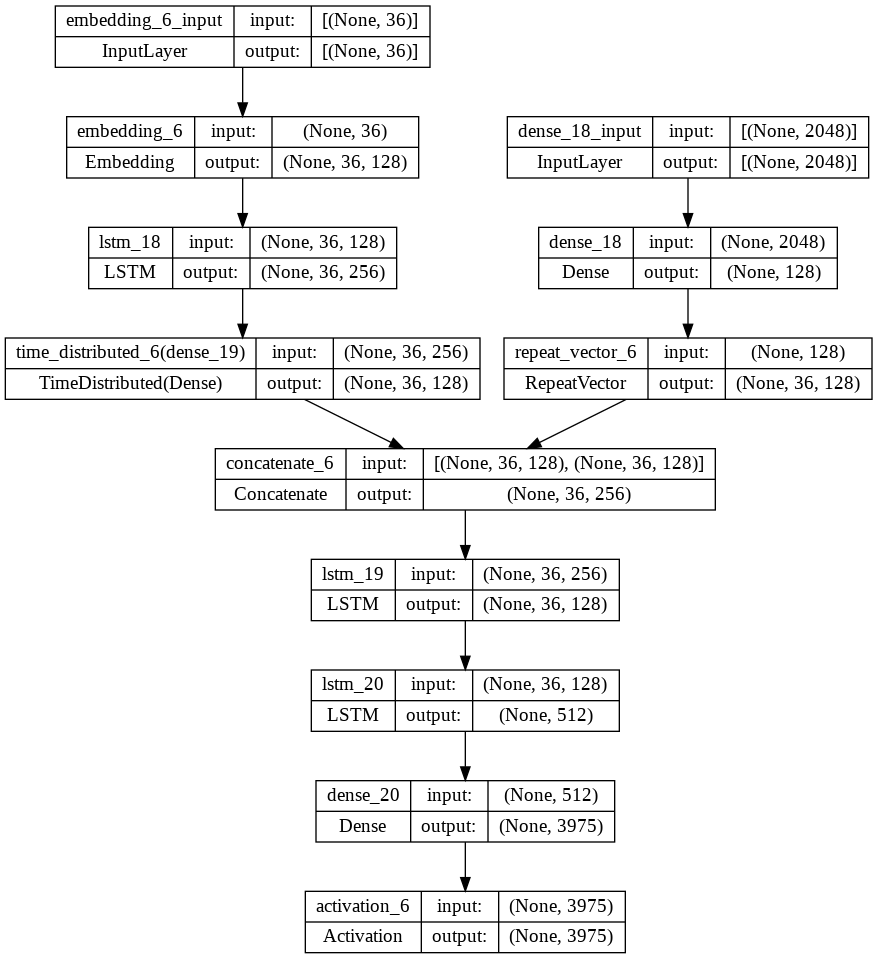

In [107]:
from keras.utils import plot_model
plot_model(model, show_shapes= True)

In [109]:
model.fit([X, y_in], y_out, batch_size=512, epochs=1)

188/188 [==============================] - 865s 5s/step - loss: 5.0040 - accuracy: 0.1841


In [110]:
inv_dict = {v:k for k, v in count_words.items()}

In [111]:
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

In [112]:
test_features = modele.predict(getImage(2500)).reshape(1,2048)

1/1 [==============================] - 1s 780ms/step


In [113]:
test_features

array([[0.18590531, 0.89133656, 0.00400155, ..., 0.        , 0.        ,
        0.5892354 ]], dtype=float32)

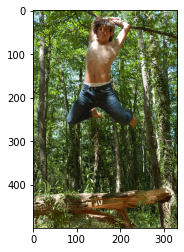

In [114]:
    test_img_path = images[2500]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    plt.imshow(test_img)

In [116]:
text_inp = ['startofseq']

count = 0
caption = ''
while count < 25:
    count += 1

    encoded = []
    for i in text_inp:
        encoded.append(count_words[i])

    encoded = [encoded]

    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


    prediction = np.argmax(model.predict([test_features, encoded]))

    sampled_word = inv_dict[prediction]

    caption = caption + ' ' + sampled_word
        
    if sampled_word == 'endofseq':
        break

    text_inp.append(sampled_word)

1/1 [==============================] - 0s 40ms/step


In [117]:
caption

' a in in a a a a a a a a . endofseq'